***Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2016 Pi-Yueh Chuang***

In [1]:
import numpy
from matplotlib import pyplot
from matplotlib import colors
% matplotlib inline

In [2]:
import functools

In [3]:
import os, sys
sys.path.append(os.path.split(os.getcwd())[0])

In [4]:
import utils.poly as poly
import utils.quadrature as quad

### A. Problem description

#### A-1. PDE

$$
\frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} = 0
$$

#### A-2. Initial condition

$$
u_{init} = e^{-40(x-0.5)^2}
$$

In [5]:
def u_init(x):
    """initial condition of u"""
    temp = x - 0.5
    return numpy.exp(-40 * temp * temp)

#### A-3. Exact solution

$$
u_{exact} = e^{\left[-40(x-0.5-t)^2\right]}
$$

In [6]:
def u_exact(x, t):
    """initial condition of u"""
    temp = x - 0.5 - t
    return numpy.exp(-40 * temp * temp)

#### A-4. Flux function

The PDE is already in conservative form.
And thus the flux of the conservation law in this problem is

$$
f(x) = f(u(x)) = u(x)
$$

In [7]:
def flux(u):
    """flux in PDE"""
    return u

#### A-5. Wave propagation speed, a

$$
a(x) = a(u) = \frac{df}{du} = 1
$$

### B. Distribution of solution points on single element

#### B-1. Equally distribution

Solution points are equally distributed on a single element but exclude the two end nodes.

In [8]:
def equalDistrib(N):
    """"""
    return numpy.linspace(-1., 1., N, endpoint=False) + 1. / N

#### B-2. Legendre-Lobatto
Solution points are the quadrature nodes of Gauss-Lobatto-Legendre quadrature.

In [9]:
def LegendreLobatto(N):
    """"""
    return quad.GaussLobattoJacobi(N).nodes

#### B-3. Gauss (or Legendre-Gauss)
Solution points are the quadrature nodes of Gauss-Legendre quadrature.

In [10]:
def LegendreGauss(N):
    """"""
    return quad.GaussJacobi(N).nodes

#### B-4. Chebyshev-Lobatto
Solution points are the quadrature nodes of Gauss-Lobatto-Chebyshev quadrature.

In [11]:
def ChebyshevLobatto(N):
    """"""
    return - numpy.cos(numpy.arange(N, dtype=numpy.float64) * numpy.pi / (N-1))

Finally, let's define a dictionary collecting these distribution functions for the purpose of later coding.

In [12]:
solnPointDistrib = {
    "equal": equalDistrib,
    "LegendreLobatto": LegendreLobatto,
    "LegendreGauss": LegendreGauss,
    "ChebyshevLobatto": ChebyshevLobatto
}

### C. Flux correction function ($g_{LB}$ and $g_{RB}$)

Though what we'll define mathematically are flux correction functions (i.e. $g_{LB}$ and $g_{RB}$), 
we only need the derivatives of these functions at solution points in numerical solvers, that is, $\frac{dg_{LB}}{d\xi}(\xi_k)$ and $\frac{dg_{RB}}{d\xi}(\xi_k)$, where $\xi_k,\ k=1,\dots,N$ are solution points on each element.
So the Python function defined below only return a `numpy.ndarray` of these derivatives.

$N$ in this section always represents the number of solution points on each element.

#### C-1. Discontinuous Galerkin, $g_{DG}$ (a.k.a. $g_1$)

$g_{DG}$ is defined as Radau polynomial (p.s. the roots of Radau polynomials are the quadrature nodes of Gauss-Radau-Legendre quadrature).

$$
\left\{
\begin{align*}
g_{DG,LB}(\xi) & = R_{R,N}(\xi) = (-1)^N\frac{1}{2}(L_N(\xi) - L_{N-1}(\xi)) \\
g_{DG,RB}(\xi) & = R_{L,N}(\xi) = \frac{1}{2}(L_N(\xi) + L_{N-1}(\xi)) \\
\end{align*}
\right.
$$

where the subscripts $LB$ and $RB$ denote whether the functions apply to left or right interface of each element; $R_{R,N}$ and $R_{L,N}$ are right- and left-Radau polynomial of order $N$; $L_N$ represents Legendre polynomial of order $N$.

In [13]:
def dgDG(xi, side):
    """flux correction scheme: discontinuous Galerkin, aka. g1
    
    This function returns the derivatives of g_{DG} at solution points
    
    Args:
        xi: numpy.ndarray, local coordinates of solution points
        side: string, either 'left' or 'right', indicating which bouyndary of 
              element will be corrected
    """
    
    # number of solution points, also the order of correction polynomial
    N = xi.size
    
    # dg/dx
    if side == 'left':
        dg = poly.Radau(N, end=1).derive()
    elif side == 'right':
        dg = poly.Radau(N, end=-1).derive()
    else:
        raise ValueError("illegal value for argument 'side'")
    return dg(xi)    

#### C-2. Correction function based on staggered-grid  spectral difference, $g_{SG}$

$g_{SG}$ is a Lagrange interpolation polynomial of which the basis polynomials are defined by Chebyshev-Lobatto points and the values at these points are zero except the targeting interface point. The value of the targeting interface point (i.e. $\xi=-1$ or $\xi=1$) is one.

$$
g_{SG}(\xi) = \sum_{i=0}^{N} g_i \prod_{\begin{smallmatrix}j=0 \\ j\ne i\end{smallmatrix}}^{N} \frac{\xi-\xi_j}{\xi_i-\xi_j}
$$

For $g_{SG,LB}$, $g_0=1$ and $g_i=0$ for $i=1,\dots,N$. While for $g_{SG,RB}$, $g_i=0$ for $k=0,\dots,N-1$ and $g_N=1$. $\xi_i,\ k=0,\dots,N$ denotes $N+1$ Chebyshev-Lobatto points.

Given that values at most basis points (i.e. $g_i$) are zero, we can further simplify it.

$$
\left\{
\begin{align*}
g_{SG,LB}(\xi) & = \prod_{\begin{smallmatrix}j=0 \\ j\ne 0\end{smallmatrix}}^{N} \frac{\xi-\xi_j}{\xi_0-\xi_j} \\
g_{SG,RB}(\xi) & = \prod_{\begin{smallmatrix}j=0 \\ j\ne N\end{smallmatrix}}^{N} \frac{\xi-\xi_j}{\xi_N-\xi_j}
\end{align*}
\right.
$$

In [14]:
def dgSG(xi, side):
    """flux correction scheme: stagger grid spectral difference
    
    This function returns the derivatives of g_{SG} at solution points
    
    Args:
        xi: numpy.ndarray, local coordinates of solution points
        side: string, either 'left' or 'right', indicating which bouyndary of 
              element will be corrected
    """
    
    # number of solution points, also the order of correction polynomial
    N = xi.size
    nodes = ChebyshevLobatto(N+1)
    
    # dg/dx
    if side == 'left':
        g = poly.Polynomial(roots=nodes[1:])
        g /= g(nodes[0])
    elif side == 'right':
        g = poly.Polynomial(roots=nodes[:-1])
        g /= g(nodes[-1])
    else:
        raise ValueError("illegal value for argument 'side'")
    
    return g.derive()(xi)

#### C-3. Lumping for Lobatto points, $g_{Lump,Lo}$ (a.k.a. $g_2$)

$g_{Lump,Lo}$ is defined through $N$ Legendre-Lobatto points, $\xi_i,\ i=1,\dots,N$.
For correction at left interface ($g_{Lump,Lo,LB}$), we want the following properties:

1. $g_{Lump,Lo,LB}(\xi_1)$=$g_{Lump,Lo,LB}(-1)=1$
2. $g_{Lump,Lo,LB}(\xi_N)$=$g_{Lump,Lo,LB}(1)=0$
3. $g'_{Lump,Lo,LB}(\xi_i)=0,\ for\ i=2,\dots,N$

Based on these properties, we can first define the differential of the function:
$$
g'_{Lump,Lo,LB}(\xi) = C_1\prod_{i=2}^{N}(\xi-xi_i)
$$
Carry out indefinite integration, we get
$$
g_{Lump,Lo,LB}(\xi) = C_1\int\prod_{i=2}^{N}(\xi-xi_i)d\xi + C_2 = C_1 p(\xi) + C_2
$$
where $p(\xi) \equiv \int\prod_{i=2}^{N}(\xi-xi_i)d\xi$. After applying the first and the second property abovementioned, we can obtain that
$$
\left\{
\begin{align*}
C_1 = & 1 \mathbin{/} (p(-1) - p(1)) \\
C_2 = & - p(1) \mathbin{/} (p(-1) - p(1))
\end{align*}
\right.
$$

For right-interface correction function, similar properties are induced:
1. $g_{Lump,Lo,RB}(\xi_N)$=$g_{Lump,Lo,RB}(1)=1$
2. $g_{Lump,Lo,RB}(\xi_1)$=$g_{Lump,Lo,RB}(-1)=0$
3. $g'_{Lump,Lo,LB}(\xi_i)=0,\ for\ i=1,\dots,N-1$

And $g_{Lump,Lo,RB}(\xi)$ can be obtained following the same workflow.

In fact, given that $\xi_i$ are Legendre-Lobatto points, we can get Radau polynomial representations of $g_{Lump,Lo}$:
$$
\left\{
\begin{align*}
g_{Lump,Lo,LB}(\xi) &= \frac{1}{2N-1}((K-1)R_{R,N}(\xi) + KR_{R,N}(\xi)) \\
g_{Lump,Lo,RB}(\xi) &= \frac{1}{2N-1}((K-1)R_{L,N}(\xi) + KR_{L,N}(\xi))
\end{align*}
\right.
$$
However, if $\xi_i$ are not Legendre-Lobatto points, we can still go through the workflow to obtain $g_{Lump,XX}$ (for example, see the next correction function), but we may not be able to get the Radau representations.

##### Additional note
If solution points are chosen to be the same as points defining $g_{Lump,XX}$, then we don't even have to define correction function nor differential of the function. This is because the derivatives of $g_{Lump,XX}$ at interior solution points are zero by definition, and the derivative at targeting interface point can be obtained analytically, while that at the other interface point is zero.

For example, if solution points are Legendre-Lobatto points, and the correction function is $g_{Lump,Lo}$, then the derivatives of $g_{Lump,Lo}$ at these solution points are
$$
\left\{
\begin{align*}
&g'_{Lump,Lo,LB}(\xi_1) = -N(N-1)/2;\ g'_{Lump,Lo,LB}(\xi_i) = 0\ for\ i=2,\dots,N\\
&g'_{Lump,Lo,RB}(\xi_N) = N(N-1)/2;\ g'_{Lump,Lo,LB}(\xi_i) = 0\ for\ i=1,\dots,N-1
\end{align*}
\right.
$$

In [15]:
def dgLumpLo(xi, side):
    """flux correction scheme: lumpped Legendre-Lobatto, aka. g2
    
    This function returns the derivatives of g_{Lump,Lo} at solution points
    
    Args:
        xi: numpy.ndarray, local coordinates of solution points
        side: string, either 'left' or 'right', indicating which bouyndary of 
              element will be corrected
    """
    
    # number of solution points, also the order of correction polynomial
    N = xi.size
    nodes = quad.GaussLobattoJacobi(N).nodes
    
    # dg/dx
    if side == 'left':
        dg = poly.Polynomial(roots=nodes[1:])
        
        g = dg.integral()  # note: this is indefinite integral!
        # correct the scaling, so that final g(-1) = 1
        leading = 1. / (g(-1) - g(1))
    elif side == 'right':
        dg = poly.Polynomial(roots=nodes[:-1])
        
        g = dg.integral()  # note: this is indefinite integral!
        # correct the scaling, so that final g(1) = 1
        leading = 1. / (g(1) - g(-1))
    else:
        raise ValueError("illegal value for argument 'side'")
    
    return dg(xi) * leading

#### C-4. Lumping for Chebyshev-Lobatto points, $g_{Lump,Ch-Lo}$

$g_{Lump,Ch-Lo}$ is defined by the same definitions of $g_{Lump,Lo}$, except now the points defining the function (i.e. $\xi_i$) are Chebyshev-Lobatto points. Therefore, we can get $g_{Lump,Ch-Lo}$ through the same workflow of $g_{Lump,Lo}$.

In [16]:
def dgLumpChLo(xi, side):
    """flux correction scheme: lumpped Chebyshev-Lobatto, aka. g2
    
    This function returns the derivatives of g_{Lump,Ch-Lo} at solution points
    
    Args:
        xi: numpy.ndarray, local coordinates of solution points
        side: string, either 'left' or 'right', indicating which bouyndary of 
              element will be corrected
    """
    
    # number of solution points, also the order of correction polynomial
    N = xi.size
    nodes = ChebyshevLobatto(N)
    
    # dg/dx
    if side == 'left':
        dg = poly.Polynomial(roots=nodes[1:])
        
        g = dg.integral()  # note: this is indefinite integral!
        # correct the scaling, so that final g(-1) = 1
        leading = 1. / (g(-1) - g(1))
    elif side == 'right':
        dg = poly.Polynomial(roots=nodes[:-1])
        
        g = dg.integral()  # note: this is indefinite integral!
        # correct the scaling, so that final g(1) = 1
        leading = 1. / (g(1) - g(-1))
    else:
        raise ValueError("illegal value for argument 'side'")
    
    return dg(xi) * leading

#### C-5. Staggered-grid scheme with Gauss points, $g_{Ga}$

The definition of $g_{Ga}$ follows the same concept of $g_{SG}$, except that now the points defining Lagrange basis polynomial are $N-1$ Gauss points plus $\xi=-1$ and $\xi=1$ at the ends. That is,
$$
\left\{
\begin{align*}
&\xi_0 = -1 \\
&\xi_N = 1 \\
&\xi_i = the\ i_{th}\ root\ of\ L_{N-1}(\xi),\ for\ i=1,\dots,N-1
\end{align*}
\right.
$$
The remaining part of the definition follows that of $g_{SG}$.

In [17]:
def dgGa(xi, side):
    """flux correction scheme: stagger grid spectral difference, but with Gauss
    quadrature points as interior zeros
    
    This function returns the derivatives of g_{Ga} at solution points
    
    Args:
        xi: numpy.ndarray, local coordinates of solution points
        side: string, either 'left' or 'right', indicating which bouyndary of 
              element will be corrected
    """
    
    # number of solution points, also the order of correction polynomial
    N = xi.size
    nodes = numpy.pad(quad.GaussJacobi(N-1).nodes, 
                      (1, 1), 'constant', constant_values=(-1., 1.))
    
    # dg/dx
    if side == 'left':
        g = poly.Polynomial(roots=nodes[1:])
        g /= g(nodes[0])
    elif side == 'right':
        g = poly.Polynomial(roots=nodes[:-1])
        g /= g(nodes[-1])
    else:
        raise ValueError("illegal value for argument 'side'")
    
    return g.derive()(xi)

Again, let's define a dictionary to collect these correction function.

In [18]:
dCorrectionFunc = {
    "DG": dgDG,
    "SG": dgSG,
    "LumpLo": dgLumpLo,
    "LumpChLo": dgLumpChLo,
    "Ga": dgGa
}

### D. Solver and related functions

#### D-1. 4th order explicit Runge-Kutta

In [19]:
def RK4(u, dt, rhs):
    """4th order explicit Runge-Kutta"""
    k1 = rhs(u)
    k2 = rhs(u+0.5*dt*k1)
    k3 = rhs(u+0.5*dt*k2)
    k4 = rhs(u+dt*k3)
    u += dt * (k1 + 2. * k2 + 2. * k3 + k4) / 6.
    return u

#### D-2. Flux reconstruction

In [20]:
def FR1D(u, basis, dMatrix, intID, dgL, dgR, invJ):
    """flux reconstruction
    
    Args:
        u: Ne by K numpy ndarray (Ne: number of elements; K: number of solution
            points per element); primary variable in PDE
        basis: Lagrange basis polynomial based on solution points on each 
            element; so far, given that the domain is discretized by the same 
            type of standard element, so only one set of Lagrange basis is 
            required
        dMatrix: derivative matrix associated to the given Lagrnage basis
        intID: Ne+1 by 2 numpy integer ndarray; array indicating the id of left
            and right elements at each interface
        dgL, dgR: numpy ndarray with length K; correction values of locally 
            derived flux due to left and right interfaces; given that the 
            distributions and orders of solution points on all elements are the
            same, all elements share the same dgL and dgR (because they only 
            depend on local coordinate)
        invJ: float; inversed Jacobian; due to the size of elements in this 
            problem are the same, all elements share single invJ
    """
    
    # obtain number of elements and number of solution points per element
    Ne, K = u.shape
    
    # upwind flux at each interface
    # note: in this problem, a = df/du = 1, so upwind values always come from
    # the left elements of interfaces
    fupw = numpy.array(
        [numpy.dot(basis(1), u[intID[i, 0]]) for i in range(Ne+1)])

    # dF/dxi, local derived and corrected flux
    RHS = numpy.zeros_like(u)
    for i in range(Ne):
        f = u[i]  # for this problem, flux is u itself
        df = numpy.dot(dMatrix, f)
        fL = numpy.dot(basis(-1), f)
        fR = numpy.dot(basis(1), f)
        RHS[i] = df + (fupw[i] - fL) * dgL + (fupw[i+1] - fR) * dgR
    
    # dF/dx = invJ * (dF/dxi)
    RHS *= invJ
    
    # in explicit time-marching schemes, RHS = - (dF/dx)
    return -RHS

In [21]:
def solve(DistribType, CorrectionType, dt, Nt):
    """
    solve the PDE with given parameters
    """
    
    xLB = 0.  # coordinate of left boundary
    xRB = 1.  # coordinate of right boundary
    L = 1.  # length of the domain (= xRB - xLB)
    Ne = 10  # number of elements
    K = 4  # number of solution points per element
    NSP = K * Ne  # total number of solution points
    
    h = L / Ne  # size of each element
    J = 0.5 * h  # Jacobian of each element
    Jinv = 2. / h  # inversed Jacobian of each element
    
    # coordinate of centers of elements
    xc = numpy.linspace(xLB, xRB, Ne, endpoint=False) + 0.5 * h
    
    # local coordinate of chosen distribution
    xSPLocal = solnPointDistrib[DistribType](K)
    
    # Lagrange basis polynomials
    basisLocal = poly.LagrangeBasis(xSPLocal)
    
    # derivative matrix
    D = basisLocal.derivative(xSPLocal)
    
    # global coordinates of all solution points
    xSPGlobal = numpy.array([xc[i] + J * xSPLocal for i in range(Ne)])
    
    # id of the two elements composing each interface
    interfaceID = numpy.column_stack(
        (numpy.arange(-1, Ne), numpy.arange(0, Ne+1)))
    interfaceID[0, 0] = Ne - 1  # apply periodic BC at left boundary
    interfaceID[-1, 1] = 0  # apply periodic BC at right boundary
    
    # IC at solution points
    u = u_init(xSPGlobal)
    
    # get values of dgLB and dgRB at solution points (local)
    dgLeft = dCorrectionFunc[CorrectionType](xSPLocal, "left")
    dgRight = dCorrectionFunc[CorrectionType](xSPLocal, "right")
    
    # define RHS function using these local variables
    rhs = functools.partial(FR1D, basis=basisLocal, dMatrix=D, 
        intID=interfaceID, dgL=dgLeft, dgR=dgRight, invJ=Jinv)

    # time marching
    t = 0
    for i in range(Nt):
        u = RK4(u, dt, rhs)
        t += dt

    return xSPGlobal.flatten(), u.flatten(), t

#### D-3. Fromm's scheme

In [22]:
def FrommScheme(u, dx):
    """"""
    
    Np = u.size
    flux = numpy.zeros_like(u)
          
    # the most left point
    flux[0] = - 0.25 * (u[-2] - 5 * u[-1] + 3 * u[0] + u[1]) / dx
    
    # interior points
    for i in range(1, Np-1):
        flux[i] = - 0.25 * (u[i-2] - 5 * u[i-1] + 3 * u[i] + u[i+1]) / dx
    
    # the most right point
    flux[-1] = - 0.25 * (u[-3] - 5 * u[-2] + 3 * u[-1] + u[0]) / dx
    
    return flux

In [23]:
def solveFromm(dt, Nt):
    """a wrapper for solving advection equation with Fromm's scheme"""
    
    xBC_L = 0.
    xBC_R = 1.
    L = 1.
    Np = 40

    dx = L / Np
    
    x = numpy.linspace(xBC_L, xBC_R, Np, endpoint=False) + 0.5 * dx
    u = u_init(x)
    
    # define RHS function using local variables
    rhs = functools.partial(FrommScheme, dx=dx)

    # time marching
    t = 0
    for i in range(Nt):
        u = RK4(u, dt, rhs)
        t += dt
    
    return x, u, t

#### D-4. Plotting function

In [24]:
def plotResults(x, u, title, ax):
    """plot numerical results and exact solutions"""
    ax.plot(x, u_exact(x, 0), 'bx-', label="Exact solution")
    ax.plot(x, u, 'r.-', label="Numerical results")
    ax.set_title(title, fontsize=20)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.1, 1.05)
    ax.grid()

### E. Fig 9.1

In [25]:
fig, ax = pyplot.subplots(2, 3, True, True)
fig.suptitle("Equally spaced solution points, t=10", fontsize=25)
fig.set_figheight(8)
fig.set_figwidth(18)
pyplot.close()

In [26]:
# (a) piecewise-linear upwind (Van Lee's MUSCL)
Nt = 533; dt = 10. / Nt
x, u, t = solveFromm(dt, Nt)
plotResults(x, u, r"$Fromm's scheme$", ax[0, 0])

# (b) DG
Nt = 764; dt = 10. / Nt
x, u, t = solve("equal", "DG", dt, Nt)
plotResults(x, u, r"$DG$", ax[0, 1])

# (c) staggered-grid
Nt = 432; dt = 10. / Nt
x, u, t = solve("equal", "SG", dt, Nt)
plotResults(x, u, r"$Staggered-grid$", ax[0, 2])

# (d) Lump, Lo
Nt = 385; dt = 10. / Nt
x, u, t = solve("equal", "LumpLo", dt, Nt)
plotResults(x, u, r"$g_{Lump,Lo}$", ax[1, 0])

# (e) Ga
Nt = 490; dt = 10. / Nt
x, u, t = solve("equal", "Ga", dt, Nt)
plotResults(x, u, r"$g_{Ga}$", ax[1, 1])

# (f) Lump, Ch-Lo
Nt = 562; dt = 10. / Nt
x, u, t = solve("equal", "LumpChLo", dt, Nt)
plotResults(x, u, r"$g_{Lump,Ch-Lo}$", ax[1, 2])

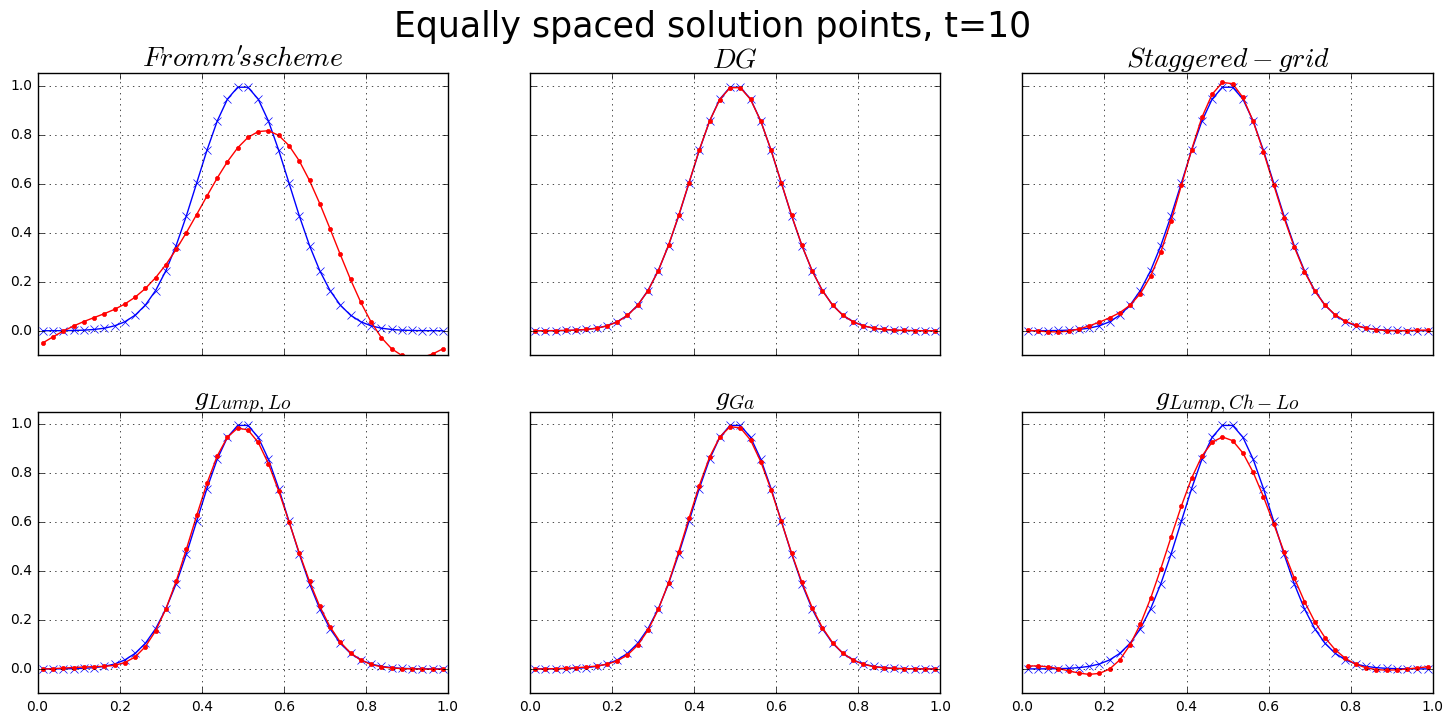

In [27]:
fig

### F. Fig 9.2

In [28]:
fig, ax = pyplot.subplots(2, 3, True, True)
fig.suptitle("Gauss solution points, t=50", fontsize=25)
fig.set_figheight(8)
fig.set_figwidth(18)
pyplot.close()

In [29]:
# (a) piecewise-linear upwind (Van Lee's MUSCL)
Nt = 2667; dt = 50. / Nt
x, u, t = solveFromm(dt, Nt)
plotResults(x, u, r"$Fromm's scheme$", ax[0, 0])

# (b) DG
Nt = 764 * 5; dt = 50. / Nt
x, u, t = solve("LegendreGauss", "DG", dt, Nt)
plotResults(x, u, r"$DG$", ax[0, 1])

# (c) staggered-grid
Nt = 432 * 5; dt = 50. / Nt
x, u, t = solve("LegendreGauss", "SG", dt, Nt)
plotResults(x, u, r"$Staggered-grid$", ax[0, 2])

# (d) Lump, Lo
Nt = 385 * 5; dt = 50. / Nt
x, u, t = solve("LegendreGauss", "LumpLo", dt, Nt)
plotResults(x, u, r"$g_{Lump,Lo}$", ax[1, 0])

# (e) Ga
Nt = 490 * 5; dt = 50. / Nt
x, u, t = solve("LegendreGauss", "Ga", dt, Nt)
plotResults(x, u, r"$g_{Ga}$", ax[1, 1])

# (f) Lump, Ch-Lo
Nt = 562 * 5; dt = 50. / Nt
x, u, t = solve("LegendreGauss", "LumpChLo", dt, Nt)
plotResults(x, u, r"$g_{Lump,Ch-Lo}$", ax[1, 2])

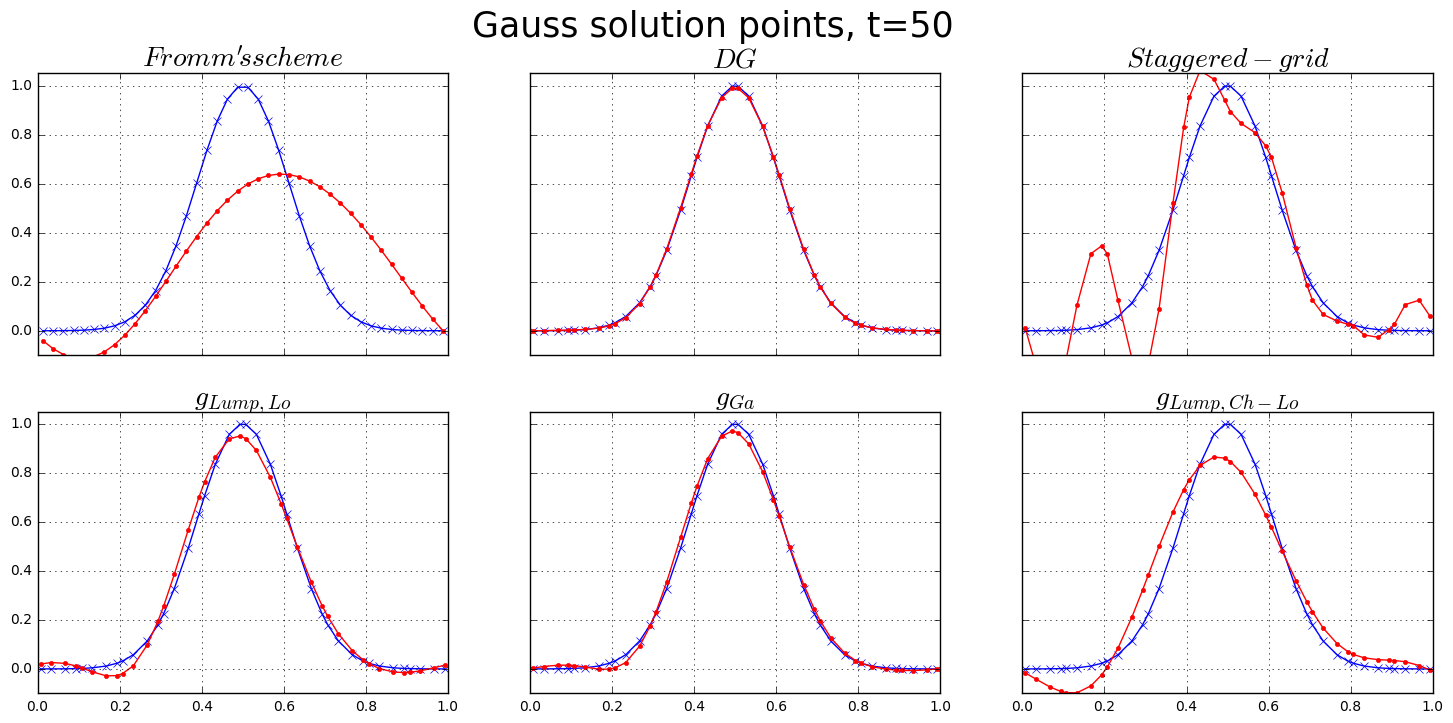

In [30]:
fig